# SemEval-2020 Task 4: Commonsense Validation and Explanation
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10ObkP2_NDn4rJ2nb9ZRn5EV9Na87vapH#scrollTo=ulk9UQVeodI-?usp=sharing)

## Subtask A BERT

### Setup

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

X_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Training/subtaskA_data_all.csv', index_col=0)
X_dev   = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Dev/subtaskA_dev_data.csv',      index_col=0)
X_test  = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Test/subtaskA_test_data.csv',    index_col=0)

y_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Training/subtaskA_answers_all.csv', index_col=0, header=None)
y_dev   = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Dev/subtaskA_gold_answers.csv',     index_col=0, header=None)
y_test  = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/Test/subtaskA_gold_answers.csv',    index_col=0, header=None)

print('Number of training data:    {:6,d}\n'.format(X_train.shape[0]))
print('Number of development data: {:6,d}\n'.format(X_dev.shape[0]))
print('Number of testing data:     {:6,d}\n'.format(X_test.shape[0]))

Number of training data:    10,000

Number of development data:    997

Number of testing data:      1,000



In [ ]:
# Make a list of sentences pairs.
sentences_pairs_train = X_train.values.tolist()
sentences_pairs_dev   = X_dev.values.tolist()
sentences_pairs_test  = X_test.values.tolist()

# Make a list of labels.
labels_train_list = y_train[1].tolist()
labels_dev_list   = y_dev[1].tolist()
labels_test_list  = y_test[1].tolist()

### BERT Tokenizer

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.0MB 22.7MB/s 
     |████████████████████████████████| 3.2MB 25.9MB/s 
     |████████████████████████████████| 870kB 49.1MB/s 


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Calculate max sentence length
max_len = 0
for sent_pair in sentences_pairs_train:
    for sent in sent_pair:
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  27


In [ ]:
def tokenize(sentences_pairs):
    input_ids       = []
    attention_masks = []
    for sent_pair in sentences_pairs:
        # `batch_encode_plus` will:
        #   (1) Tokenize the sentences.
        #   (2) Prepend the `[CLS]` token to the start of the sentence.
        #   (3) Append the `[SEP]` token to the end of the sentence.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentences to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
            sent_pair,                    # Sentences to encode.
            add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
            max_length = 32,              # Pad & truncate all sentences.
            padding = 'max_length',
            return_attention_mask = True, # Construct attn. masks.
            return_tensors = 'pt',        # Return pytorch tensors.
        )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'].flatten().unsqueeze(0))
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'].flatten().unsqueeze(0))
    return input_ids, attention_masks

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train, attention_masks_train = tokenize(sentences_pairs_train)
input_ids_dev,   attention_masks_dev   = tokenize(sentences_pairs_dev)
input_ids_test,  attention_masks_test  = tokenize(sentences_pairs_test)

In [ ]:
# Convert the lists into tensors.
input_ids_train       = torch.cat(input_ids_train,       dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)

input_ids_dev       = torch.cat(input_ids_dev,       dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)

input_ids_test       = torch.cat(input_ids_test,       dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_train = torch.tensor(labels_train_list)
labels_dev   = torch.tensor(labels_dev_list)
labels_test  = torch.tensor(labels_test_list)

### Prepare dataset iterators

In [ ]:
from torch.utils.data import TensorDataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_dev   = TensorDataset(input_ids_dev,   attention_masks_dev,   labels_dev)
dataset_test  = TensorDataset(input_ids_test,  attention_masks_test,  labels_test)

### Prepare dataset loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and development sets.
# We'll take training samples in random order. 
dataloader_train = DataLoader(
    dataset_train,  # The training samples.
    sampler = RandomSampler(dataset_train), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

# For validation the order doesn't matter, so we'll just read them sequentially.
dataloader_dev = DataLoader(
    dataset_dev, # The validation samples.
    sampler = SequentialSampler(dataset_dev), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

### Create our model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(dataloader_train) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

### Training loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
        
    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader_train), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(
            b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels
        )
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(dataloader_train)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dataloader_dev:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(
                b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,
                labels=b_labels
            )
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dataloader_dev)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dataloader_dev)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:15.
  Batch    80  of    313.    Elapsed: 0:00:30.
  Batch   120  of    313.    Elapsed: 0:00:44.
  Batch   160  of    313.    Elapsed: 0:00:58.
  Batch   200  of    313.    Elapsed: 0:01:12.
  Batch   240  of    313.    Elapsed: 0:01:26.
  Batch   280  of    313.    Elapsed: 0:01:41.

  Average training loss: 0.15
  Training epcoh took: 0:01:53

Running Validation...
  Accuracy: 0.15
  Validation Loss: 0.39
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.39,0.85,0:01:52,0:00:04
2,0.22,0.39,0.85,0:01:52,0:00:04
3,0.22,0.39,0.85,0:01:52,0:00:04
4,0.22,0.39,0.85,0:01:52,0:00:04


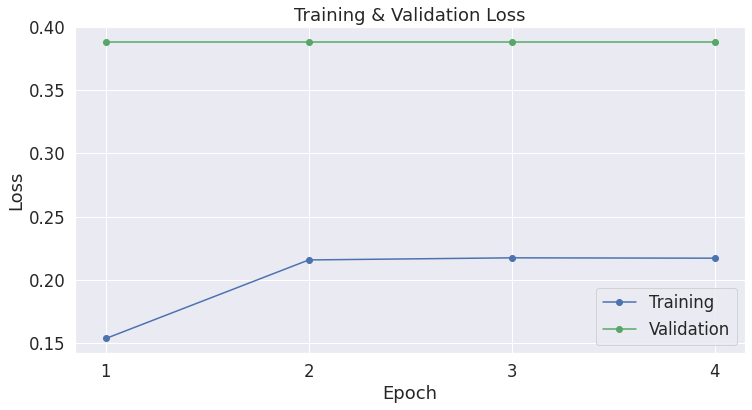

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()